In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import copy
import cv2
from queue import PriorityQueue
from typing import List, Tuple, Dict, Set

In [2]:
def arr(*l):
    return np.array(l)


INF = int(1e9)

class CacRegion:
    def __init__(self, ccw, color):
        self.ccw_pts_id = ccw
        self.color = color

In [ ]:
"""
测试时进需要修改本单元格的数据
"""

# [可视化图像宽高]
GLB_H = 240
GLB_W = 160
GLOBAL_MAT = np.zeros((GLB_H, GLB_W), dtype=int)

# [数字颜色对应关系]
CMAP = {-1: 'black', 0: 'grey', 1: 'blue', 2: 'yellow', 3: 'red', 4: 'cyan'}

# [定义所有顶点]
SEG_PTS = [
    [  6,  48],
    [  6,  60],
    [ 18,  60],
    [ 18, 144],
    [ 44, 144],
    [ 44,  60],
    [ 44,  38],
    [ 72,  38],
    [ 72,  40],
    [ 72,  42],
    [ 58,  42],
    [ 58, 158],
    [ 94, 158],
    [ 94,  40],
    [ 94,  38],
    [ 96,  38],
    [ 98,  38],
    [ 98,  94],
    [ 98, 158],
    [168, 158],
    [238, 158],
    [238,  94],
    [238,   0],
    [168,   0],
    [ 96,   0],
    [ 18,   0],
    [ 18,  38],
    [ 18,  48],
    [168,  94]
]

# 指定前几个作为房间边缘，剩下点是不在边缘上的点
SEG_EDGE_PT_NUM = len(SEG_PTS) - 1

# 指定各个区域的边界点（所有区域无交，最好将房间全覆盖）
# 方式：CacRegion([点1, 点2, ..., 点n], 颜色)
CAC_REGIONS_FAKE = [
    CacRegion([2, 1, 0, 27], 0),
    CacRegion([5, 2, 27, 26, 6], 0),
    CacRegion([6, 26, 25, 24, 15, 14, 13, 8, 7], 0),
    CacRegion([4, 3, 2, 5], 4),
    CacRegion([13, 12, 11, 10, 9, 8], 4),
    CacRegion([28, 17, 16, 15, 24, 23], 4),
    CacRegion([19, 18, 17, 28], 3),
    CacRegion([20, 19, 28, 21], 1),
    CacRegion([21, 28, 23, 22], 2),
]
# 分水器所在区域编号
ROOT_REGION_IDX = 0

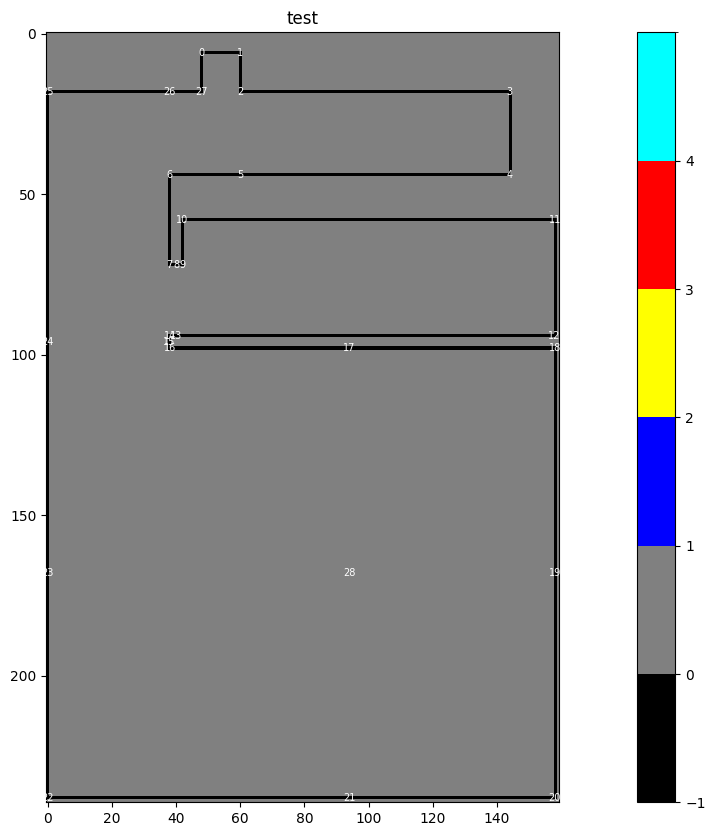

In [4]:
def seg_pts(pts: list, close=False):
    z = zip(pts, pts[1:] + [pts[0]]) if close else zip(pts[:-1], pts[1:])
    blacks = []
    lx, ly = -1, -1
    for pt, nt in z:
        cnt = int(np.ceil(max(abs(pt[0] - nt[0]), abs(pt[1] - nt[1]))))
        for i in range(cnt + 1):
            x = int(np.round(pt[0] + (nt[0] - pt[0]) * i / cnt))
            y = int(np.round(pt[1] + (nt[1] - pt[1]) * i / cnt))
            if (x, y) != (lx, ly):
                lx, ly = x, y
                blacks.append((x, y))
    return blacks


BLACKS = seg_pts(SEG_PTS[:SEG_EDGE_PT_NUM], close=True)
for x, y in BLACKS:
    GLOBAL_MAT[x, y] = -1


def plot_matrix(matrix, title=None):
    cmap_list = [CMAP[key] for key in sorted(CMAP.keys())]
    custom_cmap = mcolors.ListedColormap(cmap_list)
    bounds = list(CMAP.keys()) + [max(CMAP.keys()) + 1]
    norm = mcolors.BoundaryNorm(bounds, custom_cmap.N)
    if title is not None:
        plt.title(title)
    plt.imshow(matrix, cmap=custom_cmap, norm=norm)
    plt.colorbar(ticks=sorted(CMAP.keys()))


def plot_num(nums):
    for idx, (x, y) in enumerate(nums):
        plt.text(y, x, str(idx), color='white', fontsize=7, ha='center', va='center')   

plt.figure(figsize=(20, 10))  # 设置图像大小为 12x7
plot_matrix(GLOBAL_MAT, title='test')
plot_num(SEG_PTS)
plt.show()

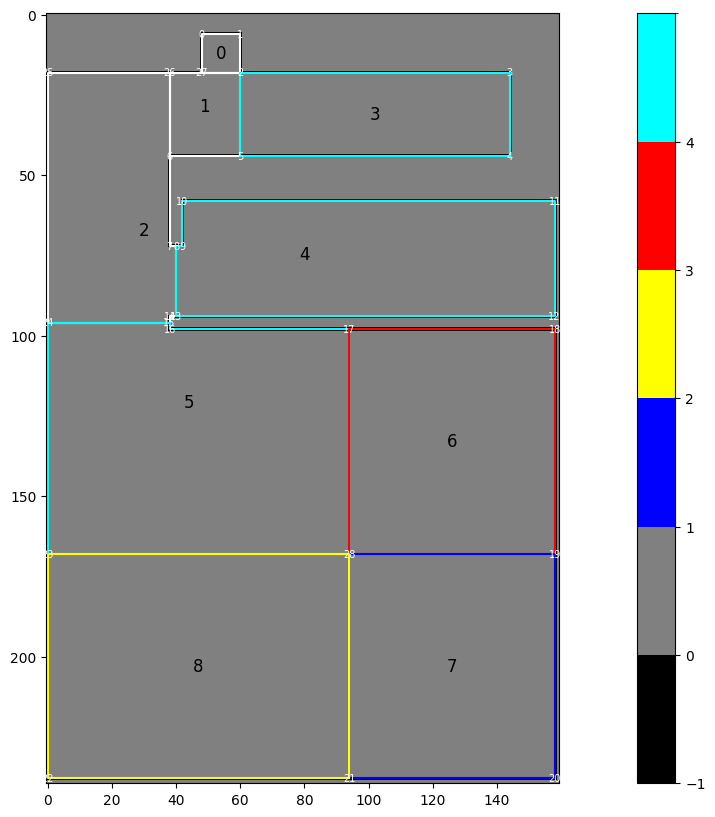

In [5]:
def plot_regions_with_colors(matrix, regions, seg, cmap):
    cmap_list = [cmap[key] for key in sorted(cmap.keys())]
    custom_cmap = mcolors.ListedColormap(cmap_list)
    bounds = list(cmap.keys()) + [max(cmap.keys()) + 1]
    norm = mcolors.BoundaryNorm(bounds, custom_cmap.N)
    
    plt.imshow(matrix, cmap=custom_cmap, norm=norm)
    for idx, region in enumerate(regions):
        x, y = zip(*[seg[i] for i in region.ccw_pts_id])
        x = list(x) + [x[0]]  # 首尾相连
        y = list(y) + [y[0]]  # 首尾相连
        plt.plot(y, x, color=CMAP[region.color] if region.color > 0 else 'white')  # 绘制多边形边缘，颜色为白色
        
        # 计算质心
        centroid_x = sum(x[:-1]) / len(x[:-1])
        centroid_y = sum(y[:-1]) / len(y[:-1])
        plt.text(centroid_y, centroid_x, str(idx), color='black', fontsize=12, ha='center', va='center')  # 显示编号
    
    plt.colorbar(ticks=sorted(cmap.keys()))

plt.figure(figsize=(20, 10))  # 设置图像大小为 20x10
plot_regions_with_colors(GLOBAL_MAT, CAC_REGIONS_FAKE, SEG_PTS, CMAP)
plot_num(SEG_PTS)
plt.show()


In [6]:
def edge_id(tu) -> Tuple:
    return min(tu), max(tu)

class EdgePipes:
    def __init__(self, pipes=None):
        self.ccw_pipes = pipes if pipes is not None else list()
    
    def insert_pipe(self, x_lt_y, idx, pipe_seg_id):
        self.ccw_pipes.insert(idx if x_lt_y else len(self.ccw_pipes) - idx, pipe_seg_id)
    def get_pipes(self, x_lt_y):
        return self.ccw_pipes if x_lt_y else list(reversed(self.ccw_pipes))

In [7]:
# dijkstra 求各个 Region 反向 dijkstra 顺序
PT_EDGE_TO = [[] for _ in range(len(SEG_PTS))]
for r in CAC_REGIONS_FAKE:
    for x, y in zip(r.ccw_pts_id, r.ccw_pts_id[1:] + [r.ccw_pts_id[0]]):
        PT_EDGE_TO[x].append(y)
        PT_EDGE_TO[y].append(x)
# 每个点的出点按极角排序 -pi ~ pi
for id in range(len(SEG_PTS)):
    # 去重
    PT_EDGE_TO[id] = list(set(PT_EDGE_TO[id]))
    PT_EDGE_TO[id] = sorted(PT_EDGE_TO[id], key=lambda x: np.arctan2(SEG_PTS[x][1] - SEG_PTS[id][1], SEG_PTS[x][0] - SEG_PTS[id][0]))

def pt_dis(pt1, pt2):
    return np.sqrt((pt1[0] - pt2[0]) ** 2 + (pt1[1] - pt2[1]) ** 2)

def dijk1():
    dis = np.ones(len(SEG_PTS), dtype=float) * INF
    q = PriorityQueue()
    for x in CAC_REGIONS_FAKE[ROOT_REGION_IDX].ccw_pts_id:
        q.put((0, x))
        dis[x] = 0
    while not q.empty():
        _, pt = q.get()
        for y in PT_EDGE_TO[pt]:
            if dis[y] > dis[pt] + pt_dis(SEG_PTS[pt], SEG_PTS[y]):
                dis[y] = dis[pt] + pt_dis(SEG_PTS[pt], SEG_PTS[y])
                q.put((dis[y], y))
    return dis

PTS_DIS = dijk1()

CAC_REGIONS_DIS = [min([PTS_DIS[x] for x in r.ccw_pts_id]) for r in CAC_REGIONS_FAKE]

In [8]:
class DisjointSet:
    def __init__(self):
        self.fa_di = dict()
        ...

    def add(self, *xs):
        for x in xs:
            if x not in self.fa_di:
                self.fa_di[x] = x

    def find(self, x):
        if self.fa_di[x] != x:
            self.fa_di[x] = self.find(self.fa_di[x])
        return self.fa_di[x]

    def mix(self, x, y):
        self.fa_di[self.find(x)] = self.find(y)

    def get_sets_di(self):
        """
        anc -> its set
        """
        di = {}
        for x in self.fa_di:
            fx = self.find(x)
            if fx not in di:
                di[fx] = []
            di[fx].append(x)
        return di

    def get_ancestor_di(self):
        return { x: self.find(x) for x in self.fa_di }

# test
def test_disjoint_set():
    ds = DisjointSet()
    ds.add(1)
    ds.add(2)
    assert(ds.find(1) == 1)
    ds.mix(1, 2)
    assert(ds.find(1) == 2)

    print(ds.get_sets_di())

    ds.add(3)
    ds.add(4)
    print(ds.get_sets_di())
    ds.add(5)
    ds.mix(3, 4)
    print(ds.get_sets_di())
    assert(ds.find(3) == 4)
    ds.mix(1, 4)
    assert(ds.find(1) == 4)
    assert(ds.find(2) == 4)
    assert(ds.find(3) == 4)
    assert(ds.find(5) == 5)
    assert(ds.get_sets_di() == {4: [1, 2, 3, 4], 5: [5]})
    print(ds.get_ancestor_di())
        
test_disjoint_set()

{2: [1, 2]}
{2: [1, 2], 3: [3], 4: [4]}
{2: [1, 2], 4: [3, 4], 5: [5]}
{1: 4, 2: 4, 3: 4, 4: 4, 5: 5}


--- 0 ---
--- 1 ---
--- 3 ---
--- 2 ---
--- 4 ---
insert 8 -> 7 at 0, color 4 pipe_id 28
insert 7 -> 6 at 0, color 4 pipe_id 29
insert 6 -> 5 at 0, color 4 pipe_id 30
mix 5 {2, 30}
mix 6 {29, 30}
mix 7 {28, 29}
mix 8 {8, 28}
--- 5 ---
insert 15 -> 14 at 0, color 4 pipe_id 31
insert 14 -> 13 at 0, color 4 pipe_id 32
mix 5 {2, 30}
mix 6 {29, 30}
mix 7 {28, 29}
mix 8 {9, 28}
mix 13 {32, 9}
mix 14 {32, 31}
mix 15 {12, 31}
--- 6 ---
insert 28 -> 23 at 1, color 3 pipe_id 33
insert 23 -> 24 at 1, color 3 pipe_id 34
insert 24 -> 25 at 0, color 3 pipe_id 35
insert 25 -> 26 at 0, color 3 pipe_id 36
insert 26 -> 27 at 0, color 3 pipe_id 37
mix 23 {33, 34}
mix 24 {34, 35}
mix 25 {35, 36}
mix 26 {36, 37}
mix 28 {33, 18}
--- 8 ---
insert 23 -> 24 at 2, color 2 pipe_id 38
insert 24 -> 25 at 1, color 2 pipe_id 39
insert 25 -> 26 at 1, color 2 pipe_id 40
insert 26 -> 27 at 1, color 2 pipe_id 41
mix 23 {26, 38}
mix 24 {38, 39}
mix 25 {40, 39}
mix 26 {40, 41}
--- 7 ---
insert 28 -> 23 at 1, color 1 pipe_

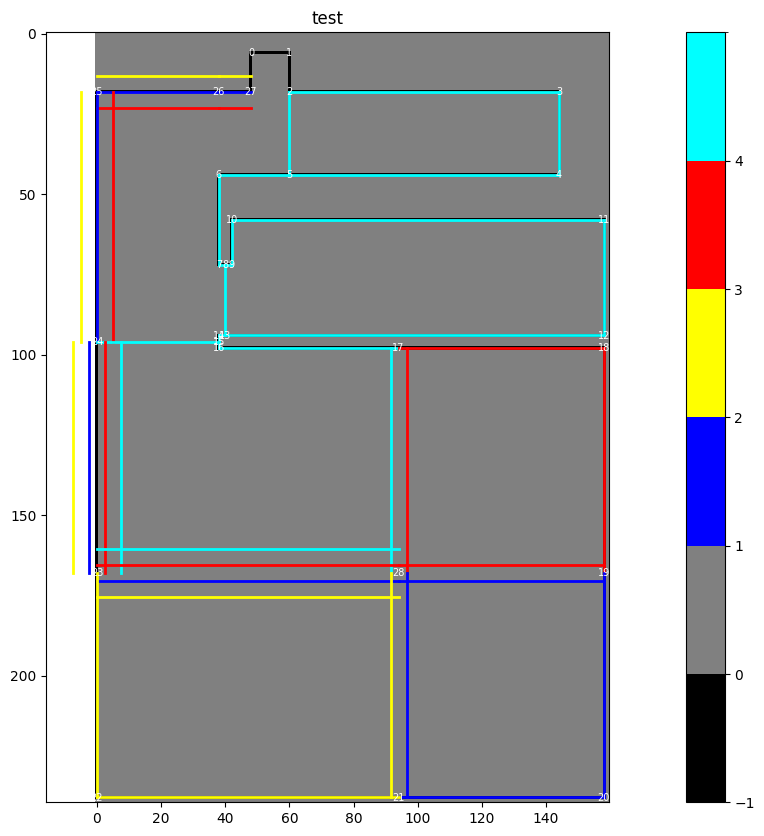

In [9]:
StateT = Tuple[int, int, int]
TransferT = Dict[StateT, List[Tuple[StateT, float]]]

def get_djk_states_for_color_at_pt(pt_to, color, pt, edge_pipes: Dict[Tuple[int, int], EdgePipes], pipe_color) -> List[StateT]:
    """
    保证逆时针给出
    """
    # from -pi to pi
    # 同色: i 直接对应管道在 EdgePipes 上的编号（存这个编号是为了方便插入）
    # 异色或边缘: i 对应 i 和 i - 1 之间的管道，将新成为 i
    states = []
    for y in pt_to[pt]:
        # pt -> y 方向的逆时针
        eid = edge_id((pt, y))
        ccw_pipes = edge_pipes[eid].ccw_pipes
        # i: color 相同或位于 0 号位置或左边为异色
        # 最右边且左边为异色
        i2 = []
        for i in list(range(len(edge_pipes[eid].ccw_pipes) + 1)):
            if i == 0:
                i2.append(i)
                continue
            if i == len(ccw_pipes):
                if pipe_color[ccw_pipes[i - 1]] != color:
                    i2.append(i)
                continue
            if pipe_color[ccw_pipes[i]] == color or pipe_color[ccw_pipes[i - 1]] != color:
                i2.append(i)
        if pt > y:
            i2 = list(reversed(i2))
        for i in i2:
            states.append((pt, y, i))
    return states

def test_get_djk_states_for_color_at_pt():
    # 随便构建一张图
    pt_to = [[1], [3, 0, 2, 4], [1], [1], [1]]
    edge_pipes = {
        (0, 1): EdgePipes([8, 7]),
        (1, 2): EdgePipes([1, 2, 3, 0]),
        (1, 3): EdgePipes([6, 4, 5]),
        (1, 4): EdgePipes(),
    }
    pipe_color = [6, 7, 6, 1, 7, 6, 6, 7, 1]
    states = get_djk_states_for_color_at_pt(pt_to, 1, 1, edge_pipes, pipe_color)
    # print(states)
    states = get_djk_states_for_color_at_pt(pt_to, 1, 2, edge_pipes, pipe_color)
    # print(states)
    assert(tuple(states)== tuple([(2, 1, 4), (2, 1, 2), (2, 1, 1), (2, 1, 0)]))
    # 输出 [(2, 1, 4)]? 表示一个在 2 点上，指向 1 的边上，在 (1, 2) 边的第 4 个管道L位置上

test_get_djk_states_for_color_at_pt()


def test_get_djk_states_for_color_at_pt2():
    # 随便构建一张图
    pt_to = [[1], [3, 0, 2, 4], [1], [1], [1]]
    edge_pipes = {
        (0, 1): EdgePipes([8, 7]),
        (1, 2): EdgePipes([1, 2, 3, 0]),
        (1, 3): EdgePipes([6, 4, 5]),
        (1, 4): EdgePipes(),
    }
    pipe_color = [6, 7, 6, 1, 7, 6, 6, 7, 1]
    state_set = set()
    for pt in range(5):
        states = get_djk_states_for_color_at_pt(pt_to, 1, pt, edge_pipes, pipe_color)
        for state in states:
            state_set.add(state)
    for st in state_set:
        pt, y, i = st
        assert((y, pt, i) in state_set)

test_get_djk_states_for_color_at_pt2()

def get_djk_transfer_for_color(pt_to, region_color, edge_pipes, pipe_color, seg_pts, pt_pipe_sets) -> TransferT:
    transfer: TransferT = dict()
    # List as Dict
    ccw_djk_states_of_pt = [get_djk_states_for_color_at_pt(pt_to, region_color, pt, edge_pipes, pipe_color) for pt in range(len(seg_pts))]
    # print(f'{edge_pipes[(2, 3)].ccw_pipes}, {edge_pipes[(4, 5)].ccw_pipes}')
    for pt in range(len(seg_pts)):
        djk_states: List[StateT] = ccw_djk_states_of_pt[pt]
        for s in djk_states:
            transfer[s] = []
            inv = (s[1], s[0], s[2])
            # check color
            ccw_pipe_li = edge_pipes[edge_id((s[0], s[1]))].ccw_pipes
            if s[2] < len(ccw_pipe_li) and region_color == pipe_color[ccw_pipe_li[s[2]]]:
                transfer[s].append((inv, 0))
            else:
                transfer[s].append((inv, pt_dis(seg_pts[s[0]], seg_pts[s[1]])))

        # 遍历任何一个状态为 [[set1_id(祖先), set1_cnt], [set2_id, set2_cnt], ...]
        # 
        # 更新 cnt 方式: 根据 edge pipe idx 找到对应的 pipe id
        pipe_sets_di = pt_pipe_sets[pt].get_sets_di()
        ancestor_di = pt_pipe_sets[pt].get_ancestor_di()
        # 记录祖先对应集合的元素的出现次数
        cnt_di = { x: 0 for x in pipe_sets_di.keys() if pipe_color[x] != region_color }
        def key(di):
            """
            传入 cnt_di，转换为键（忽略同色即若 pipe_color[k] == color 则不采纳键值对）
            &pipe_color
            """
            # return tuple(sorted(di.items()))
            return tuple(sorted([x for x in di.items() if pipe_color[x[0]] != region_color]))
        def go_through(x, y, st, ed):
            """
            &mut: cnt_di
            &ancestor_di
            &cnt_state_sets
            &edge_pipes
            &region_color
            &pipe_color

            方案 10L -> 方案 8L ，路过了 9, 8
            方案 0L -> 方案 2L: 路了 0, 1
            接同色 / 生长本颜色
            """
            eid = edge_id((x, y))
            pipes = edge_pipes[eid].ccw_pipes
            st, ed = np.clip(st, 0, len(pipes)), np.clip(ed, 0, len(pipes))
            def ccw_cross_i(i):
                pipe_id = pipes[i]
                if pipe_color[pipe_id] == region_color:
                    return
                sz = len(pipe_sets_di[ancestor_di[pipe_id]])
                cnt_di[ancestor_di[pipe_id]] += 1
                cnt_di[ancestor_di[pipe_id]] %= sz
            # [NOTE] 这里其实不用判断方向
            if st < ed:
                for i in range(st, ed):
                    # 越过 i 号现存管道，统计 cnt 变化
                    ccw_cross_i(i)
            else:
                for i in range(st - 1, ed - 1, -1):
                    ccw_cross_i(i)
                    
        ls = djk_states[0]
        cnt_state_sets: Dict[Tuple, Set[StateT]] = { key(cnt_di): { ls } }
        for s in djk_states[1:]:
            # 更新 cnt_di
            if s[1] == ls[1]:
                # 内部判断走向
                go_through(ls[0], ls[1], ls[2], s[2])
            else:
                # 不是同一个边内的，这里得判断走向
                if ls[0] < ls[1]:
                    go_through(ls[0], ls[1], ls[2], +INF)
                else:
                    go_through(ls[0], ls[1], ls[2], -INF)
                if s[0] < s[1]:
                    go_through(s[0], s[1], -INF, s[2])
                else:
                    go_through(s[0], s[1], +INF, s[2])
            k = key(cnt_di)
            if k not in cnt_state_sets:
                cnt_state_sets[k] = set()
            cnt_state_sets[k].add(s)
            ls = s # 不用 copy
        
        assert(np.all([v == 0 for v in cnt_di.values()]))
        # 一个 key 的所有状态可以互相到达
        for _, v in cnt_state_sets.items():
            for s in v:
                for ss in v:
                    if s != ss:
                        transfer[s].append((ss, 0))

    return ccw_djk_states_of_pt, transfer

def test_transfer():
    pt_to = [[1], [3, 0, 2, 4], [1], [1], [1]]
    edge_pipes = {
        (0, 1): EdgePipes([8, 7]),
        (1, 2): EdgePipes([0, 1, 2, 3]),
        (1, 3): EdgePipes([6, 4, 5]),
        (1, 4): EdgePipes(),
    }
    pipe_color = [1, 7, 6, 6, 6, 7, 6, 7, 1]
    seg_pts = [(3, 0), (1, 1), (2, 4), (-1, -1), (0, 4)]
    pt_pipe_sets = { x: DisjointSet() for x in range(len(seg_pts)) }
    pt_pipe_sets[0].add(7, 8)

    pt_pipe_sets[1].add(*range(9))
    pt_pipe_sets[1].mix(3, 6)
    pt_pipe_sets[1].mix(2, 4)
    pt_pipe_sets[1].mix(1, 5)
    pt_pipe_sets[1].mix(1, 7)
    pt_pipe_sets[1].mix(0, 8)

    pt_pipe_sets[2].add(0, 1, 2, 3)
    pt_pipe_sets[3].add(4, 5, 6)

    _, transfer = get_djk_transfer_for_color(pt_to, 7, edge_pipes, pipe_color, seg_pts, pt_pipe_sets)
    for k, v in transfer.items():
        print(k)
        for vv in v:
            print(' ' * 4, vv)

# test_transfer()

# color 不为零的进行考虑边上 pipes 的反向 Dijkstra
def dijk2(seg_pts, pt_to, cac_regions, cac_region_root_id, cac_regions_dis):
    """
    order:
    - 原点相关
    - 边
    - 仙人掌图相关
    
    [约定]
    - 每条边的正方向：小点 -> 大点
    - 新状态位置: 0 (0) 1 (1) 2

    - 终点为根区域边
    - 同色边代价为 0. (dijkstra 为新增边最短)
    - 如何表示 djk 状态？
        - 点，边，管道
        - 同色：直接对应 i 管道
        - 连续两个异色 / 边缘异色：挤到原 i （右边） 和 i - 1 之间
    - 初始化 edge_state. edge_state 用 CacEdge 完全表示
        - 区域边缘加管道（逆时针遍历自己，插左边）
    - 每个区域寻路：建新图
        - state
            - pt, y, pipenum
            - (edge_state, color) -> state?
                 - pipe: get_pipes
                 - x, y, i (and y, x, i)
        - transfer
    """
    djk_order = np.argsort(cac_regions_dis)
    edge_pipes: Dict[Tuple[int, int], EdgePipes]= dict()
    for r in cac_regions:
        for x, y in zip(r.ccw_pts_id, r.ccw_pts_id[1:] + [r.ccw_pts_id[0]]):
            if edge_id((x, y)) not in edge_pipes:
                edge_pipes[edge_id((x, y))] = EdgePipes()

    # 每个 Disjoint Set 存储管道线段的 id 的集合
    pt_pipe_sets: Dict[int, DisjointSet] = { x: DisjointSet() for x in range(len(seg_pts)) }
    pipe_color = list() # start from 0. 实际上是 pipe segments
    region_start_pipes = [[] for _ in range(len(cac_regions))]
    # 每个有色区域逆时针一周添加管道。相邻的添加的管道在一个 pt_pipe_seg 中
    for i, r in enumerate(cac_regions):
        if r.color == 0:
            continue
        pipes_added = []
        for x, y in zip(r.ccw_pts_id, r.ccw_pts_id[1:] + [r.ccw_pts_id[0]]):
            """
            x -> y 加一条边
            """
            pipe_color.append(r.color)
            pipe_id = len(pipe_color) - 1
            pipes_added.append(pipe_id)
            # x -> y 可能是 3 -> 2，那也是 3 -> 2 方向的最左边插入
            # 即 x <- y 的最右边
            # ex: 2 -> 3, [2 <- 1 <- 0] 从右往左存
            # insert 2 -> 3 最左边? false, 0 | 内部 (idx - 0)
            edge_pipes[edge_id((x, y))].insert_pipe(x > y, 0, pipe_id)
            region_start_pipes[i].append(pipe_id)
        
        for x, pre_pipe, nxt_pipe in zip(r.ccw_pts_id, pipes_added[-1:] + pipes_added[:-1], pipes_added):
            pt_pipe_sets[x].add(pre_pipe)
            pt_pipe_sets[x].add(nxt_pipe)
            pt_pipe_sets[x].mix(pre_pipe, nxt_pipe)

    def state_attach_region(s, region_id):
        pipes = edge_pipes[edge_id((s[0], s[1]))].ccw_pipes
        return s[2] < len(pipes) and pipes[s[2]] in region_start_pipes[region_id]
    for region_ord in djk_order:
        print(f'--- {region_ord} ---')
        region_color = cac_regions[region_ord].color
        if region_color == 0:
            continue
        djk_states_pt, transfer = get_djk_transfer_for_color(pt_to, region_color, edge_pipes, pipe_color, seg_pts, pt_pipe_sets)
        dis = {}
        # Father state
        fa_s = {}
        for pt in range(len(seg_pts)):
            for s in djk_states_pt[pt]:
                dis[s] = INF
                fa_s[s] = (-1, -1, -1)
        q = PriorityQueue()
        for pt in range(len(seg_pts)):
            for s in djk_states_pt[pt]:
                if state_attach_region(s, region_ord):
                    q.put((0, s))
                    dis[s] = 0
        while not q.empty():
            _, s = q.get()
            # 终点不用继续搜
            if s[0] not in cac_regions[cac_region_root_id].ccw_pts_id:
                for t, d in transfer[s]:
                    if dis[t] > dis[s] + d:
                        dis[t] = dis[s] + d
                        fa_s[t] = s
                        q.put((dis[t], t))
        attached0 = []
        for k, v in dis.items():
            if k[0] in cac_regions[cac_region_root_id].ccw_pts_id:
                attached0.append((k, v))
        back_s = attached0[np.argmin([v for k, v in attached0])][0]
        assert(dis[back_s] < INF) # 有解
        s_chain = [back_s]
        while not state_attach_region(back_s, region_ord):
            back_s = fa_s[back_s]
            s_chain.append(back_s)
        s_chain.reverse()

        # 在原 edge_pipes 上添加加异色的交换边

        pipe_path_at_pt = { x: set() for x in range(len(seg_pts)) }
        # 起始边加入 path set
        pipe_path_at_pt[s_chain[0][0]].add(
            edge_pipes[edge_id((s_chain[0][0], s_chain[0][1]))].ccw_pipes[s_chain[0][2]]
        )
        for s, ns in zip(s_chain[:-1], s_chain[1:]):
            if not ((s[0], s[1]) == (ns[1], ns[0])):
                assert(s[0] == ns[0] and s[1] != ns[1])
                continue
            # 以下部分假设走了一条边
            eid = edge_id((s[0], s[1]))
            pipes = edge_pipes[eid].ccw_pipes
            in_fact_same_color = s[2] < len(pipes) and pipe_color[pipes[s[2]]] == region_color
            if not in_fact_same_color:
                pipe_color.append(region_color)
                pipe_id = len(pipe_color) - 1
                edge_pipes[eid].insert_pipe(True, s[2], pipe_id)
                pt_pipe_sets[s[0]].add(pipe_id)
                pt_pipe_sets[s[1]].add(pipe_id)

                pipe_path_at_pt[s[0]].add(pipe_id)
                pipe_path_at_pt[s[1]].add(pipe_id)
                print(f'insert {s[0]} -> {s[1]} at {s[2]}, color {region_color} pipe_id {pipe_id}')
            else:
                pipe_id = pipes[s[2]]
                pipe_path_at_pt[s[0]].add(pipe_id)
                pipe_path_at_pt[s[1]].add(pipe_id)
                
        for pt in range(len(seg_pts)):
            pipes = pipe_path_at_pt[pt]
            if len(pipes) >= 2:
                assert(len(pipes) == 2)
                pt_pipe_sets[pt].mix(*pipes)
                print(f'mix {pt} {pipes}')

    def test_plot_transfer():
        def plot_transfer(transfer, seg_pts):
            for s, li in transfer.items():
                for t in li:
                    st = s[0]
                    ed = t[0][0]
                    d = t[1]
                    if st == ed:
                        print(s, t)
                        continue
                    start_pt = seg_pts[st]
                    end_pt = seg_pts[ed]
                    plt.arrow(start_pt[1], start_pt[0], end_pt[1] - start_pt[1], end_pt[0] - start_pt[0],
                            head_width=1, head_length=2, fc='red', ec='red')
                    mid_x = (start_pt[0] + end_pt[0]) / 2
                    mid_y = (start_pt[1] + end_pt[1]) / 2
                    plt.text(mid_y, mid_x, f'{d:.1f}', color='blue', fontsize=8, ha='center', va='center')

        plt.figure(figsize=(20, 10))
        plot_matrix(GLOBAL_MAT, title='test')
        plot_num(SEG_PTS)
        plot_transfer(transfer, SEG_PTS)
        plt.show()

    def test_plot_pipes():
        def plot_pipes(edge_pipes, seg_pts, pipe_color, cmap):
            for (x, y), edge in edge_pipes.items():
                st, ed = np.array(seg_pts[x]), np.array(seg_pts[y])
                def normalized(v):
                    return v / np.linalg.norm(v)
                dir = normalized(ed - st)
                dir_left = np.array([-dir[1], dir[0]])
                oy, ox = dir_left * 5

                sti = -len(edge.ccw_pipes) / 2 + 0.5
                for idx, pipe_id in enumerate(edge.ccw_pipes):
                    color = cmap[pipe_color[pipe_id]]
                    i = idx + sti 
                    plt.plot([st[1] + i * ox, ed[1] + i * ox],
                            [st[0] + i * oy, ed[0] + i * oy],
                            color=color, linewidth=2)

        plt.figure(figsize=(20, 10))
        plot_matrix(GLOBAL_MAT, title='test')
        plot_num(SEG_PTS)
        plot_pipes(edge_pipes, SEG_PTS, pipe_color, CMAP)
        plt.show()

    test_plot_pipes()

dijk2(SEG_PTS, PT_EDGE_TO, CAC_REGIONS_FAKE, ROOT_REGION_IDX, CAC_REGIONS_DIS)
